In [1]:
!qstat -u medirz90


o0001.ten.osc.edu:
                                                                               Req'd  Req'd   Elap 
Job id               Username Queue    Name                 SessID NDS   TSK   Memory Time Use S Time 
-------------------- -------- -------- -------------------- ------ ----- ----- ------ ----- - -----
26559856             medirz90 serial   ondemand/sys/dashboa --         1     2     -- 01:00 R 00:49


In [1]:
import fitsio as ft
import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.append('/users/PHS0336/medirz90/github/LSSutils')
from lssutils import utils as ut

import healpy as hp
from lssutils.stats.nnbar import get_meandensity, MeanDensity

In [2]:
randir = '/fs/ess/PHS0336/data/rongpu/'
ran = ft.read(randir+'randoms-1-0.fits',columns=['RA','DEC'])
ran_lrgmask = ft.read(randir+'randoms-1-0lrgimask.fits')

In [3]:
assert ran.size == ran_lrgmask.size

In [4]:
lrg_mask_frac = np.zeros(256*256*12)
ranmap = np.zeros(256*256*12)
ranmap_lmask = np.zeros(256*256*12)

ranpix = ut.radec2hpix(256, ran['RA'], ran['DEC'])
for pix,mvalue in zip(ranpix,ran_lrgmask['lrg_mask']):
    ranmap[pix] += 1
    if mvalue > 1:
        ranmap_lmask[pix] += 1
sel = ranmap > 0
lrg_mask_frac[sel] = ranmap_lmask[sel]/ranmap[sel]

In [5]:
np.unique(ran_lrgmask['lrg_mask'])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 22, 24, 25, 26, 27, 28, 29, 30, 31], dtype=uint8)

In [7]:
lrg_mask_frac[~sel] = hp.UNSEEN

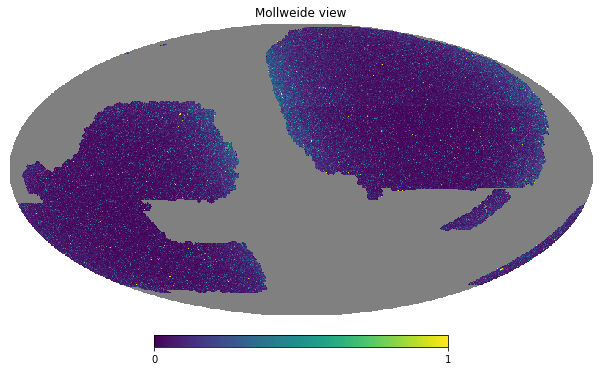

In [8]:
hp.mollview(lrg_mask_frac, rot=-95)

In [9]:
hp.write_map('/fs/ess/PHS0336/data/rongpu/lrgmask_frac.fits', lrg_mask_frac, fits_IDL=False)

/users/PHS0336/medirz90/miniconda3/envs/sysnet/lib/python3.8/site-packages/healpy/fitsfunc.py:184: FutureWarning: The default dtype of write_map() will change in a future version: explicitly set the dtype if it is important to you
  warnings.warn(


## replace extinction

In [14]:
mkdir /fs/ess/PHS0336/data/rongpu/imaging_sys/tables/0.57.1

In [15]:
for r in ['bmzls', 'ndecalsc', 'sdecalsc']:
    d = ft.read(f'/fs/ess/PHS0336/data/rongpu/imaging_sys/tables/0.57.0/nlrg_features_{r}_256.fits')
    ebv_ = lrg_mask_frac[d['hpix']]
    #print(np.percentile(ebv_, [0, 1, 99, 100]))
    d['features'][:, 0] = ebv_
    
    ft.write(f'/fs/ess/PHS0336/data/rongpu/imaging_sys/tables/0.57.1/nlrg_features_{r}_256.fits', d)
    #plt.hist(ebv_)

In [12]:
np.percentile(lrg_mask_frac, [0, 100])

array([-1.6375e+30,  1.0000e+00])

In [16]:
d = ft.read(f'/fs/ess/PHS0336/data/rongpu/imaging_sys/tables/0.57.0/nlrg_features_{r}_256.fits')
d_ = ft.read(f'/fs/ess/PHS0336/data/rongpu/imaging_sys/tables/0.57.1/nlrg_features_{r}_256.fits')

(array([8.3325e+04, 1.6987e+04, 5.0640e+03, 2.1510e+03, 9.7700e+02,
        5.2700e+02, 2.4000e+02, 1.0500e+02, 5.9000e+01, 3.6000e+01]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

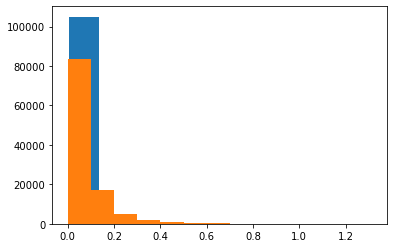

In [17]:
plt.hist(d['features'][:, 0])
plt.hist(d_['features'][:, 0])

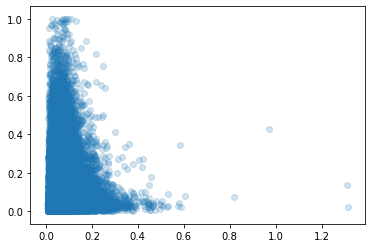

In [19]:
plt.scatter(d['features'][:, 0], d_['features'][:, 0], alpha=0.2)

## check gal density

In [8]:
wg = hp.read_map('/fs/ess/PHS0336/data/rongpu/imaging_sys/regression/0.57.0/dnnp_lrg_desic_known1.hp256.fits', verbose=False)

In [9]:
results = {}

for r in ['bmzls', 'ndecalsc', 'sdecalsc']:
    
    dt = ft.read(f'/fs/ess/PHS0336/data/rongpu/imaging_sys/tables/0.57.0/nlrg_features_{r}_256.fits')
    
    ng = ut.make_hp(256, dt['hpix'], dt['label'])
    msk = ut.make_hp(256, dt['hpix'], 1) > 0.5
    fr = ut.make_hp(256, dt['hpix'], dt['fracgood'])
    
    r_i = MeanDensity(ng, fr, msk, lrg_mask_frac)
    r_i.run()
    

    r_f = MeanDensity(ng, fr, msk, lrg_mask_frac, selection=wg)
    r_f.run()
    
    results[r] = (r_i.output, r_f.output)
    print(r)

bmzls
ndecalsc
sdecalsc


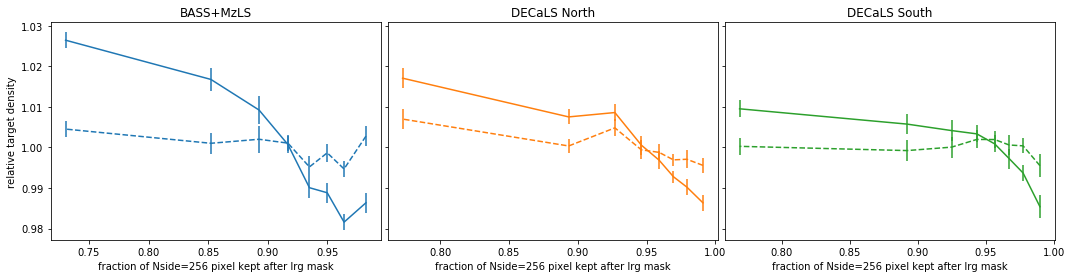

In [17]:
fg, ax = plt.subplots(ncols=3, figsize=(18, 4), sharey=True)
fg.subplots_adjust(wspace=0.02)

rr = ['BASS+MzLS', 'DECaLS North', 'DECaLS South']
for i, r in enumerate(results):
    ax[i].errorbar(1-results[r][0]['bin_avg'], results[r][0]['nnbar'], yerr=results[r][0]['nnbar_err'], color='C%d'%i)
    ax[i].errorbar(1-results[r][1]['bin_avg'], results[r][1]['nnbar'], yerr=results[r][1]['nnbar_err'], color='C%d'%i, ls='--')    
    
    ax[i].set(xlabel='fraction of Nside=256 pixel kept after lrg mask', title=rr[i])
    
ax[0].set_ylabel('relative target density')
fg.savefig('nn_fpix.png', dpi=300, bbox_inches='tight')

## Power Spectrum

In [2]:
import fitsio as ft
import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.append('/users/PHS0336/medirz90/github/LSSutils')

In [3]:
from lssutils.utils import make_hp

In [4]:
from lssutils.stats.cl import get_cl

In [5]:
help(get_cl)

Help on function get_cl in module lssutils.stats.cl:

get_cl(ngal, nran, mask, selection_fn=None, systematics=None, njack=20, nran_bar=None, lmax=None, cache_jackknifes=True, do_jack_sys=False, comm=None, cross_only=False, is_delta=False)



In [ ]:
def readd(dt):
    d = ft.read(dt)
    
    ngal = make_hp(256, d['hpix'], d['label'])
    frac = make_hp(256, d['hpix'], d['fracgood'])
    mask = make_hp(256, d['hpix'], 1) > 0.5
    
    return ngal, frac, mask

def readw(dt):
    d = ft.read(dt)
    return make_hp(256, d['hpix'], d['weight'].mean(axis=1))



for r in ['bmzls', 'ndecalsc', 'sdecalsc']:
    
    dt = readd(f'/fs/ess/PHS0336/data/rongpu/imaging_sys/tables/0.57.1/nlrg_features_{r}_256.fits')
    nnw0 = readw(f'/fs/ess/PHS0336/data/rongpu/imaging_sys/regression/0.57.0/dnnp_lrg_{r}_256_known1/nn-weights.fits')
    nnw1 = readw(f'/fs/ess/PHS0336/data/rongpu/imaging_sys/regression/0.57.1/dnnp_lrg_{r}_256_known1/nn-weights.fits')
    
    cl_before = get_cl(*dt)
    cl_after = get_cl(*dt, selection_fn=nnw0)
    cl_after1 = get_cl(*dt, selection_fn=nnw1)
    
    plt.figure()
    
    lb = ['No Weight', 'Three maps', 'Three maps (EBV->lrgmask)']
    for i, cl_i in enumerate([cl_before, cl_after, cl_after1]):
        plt.loglog(cl_i['cl_gg']['l'][2:], cl_i['cl_gg']['cl'][2:], label=lb[i])
    plt.ylim(1.0e-7, 1.0e-3)
    plt.legend(title=r.upper())
    plt.xlabel(r'$\ell$')
    plt.ylabel(r'$C_{\ell}$')
    plt.savefig(f'cl_lrgmask_{r}.png', dpi=300, bbox_inches='tight')    

In [22]:
d0 = ft.read('/fs/ess/PHS0336/data/rongpu/imaging_sys/tables/0.57.0/nlrg_features_bmzls_256.fits')
d1 = ft.read('/fs/ess/PHS0336/data/rongpu/imaging_sys/tables/0.57.1/nlrg_features_bmzls_256.fits')

In [23]:
import lssutils.utils as ut

In [27]:
ra,dec = ut.hpix2radec(256, d0['hpix'])

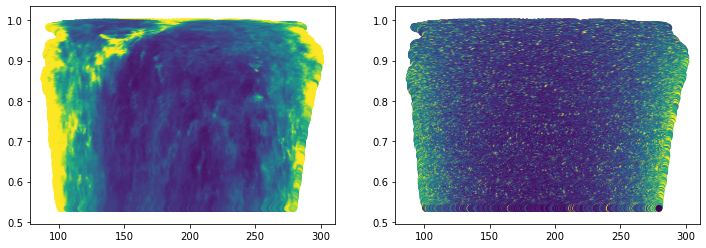

In [31]:
fg,ax = plt.subplots(ncols=2, figsize=(12, 4))

ax[0].scatter(ra, np.sin(np.deg2rad(dec)), c=d0['features'][:, 0], vmin=0., vmax=0.1)
ax[1].scatter(ra, np.sin(np.deg2rad(dec)), c=d1['features'][:, 0], vmin=0., vmax=0.4)